In [1]:
# Import all relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchsummary import summary
from torchviz import make_dot

import matplotlib.pyplot as plt
import numpy as np 
import time

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False #for a small dataset, simple network , this is not really needed
np.random.seed(seed)

/Users/waizwafiq/Documents/FSKTM/Semester 6/WIX3001 Soft Computing/wix3001_assignment/wix3001_assignment/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [36]:
# Define the directory path
data_dir = './dataset'

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))
    # transforms.Lambda(lambda x:x.view(-1))  #this flatten 28*28 into a 784 vector for each image
])

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [37]:
# Set DataLoader
batchSize = 8  # Rule of thumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train_dataset, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False) # no need to shuffle test data

In [38]:
count = 0
for xb, yb in train_loader:
  count += 1
print(f'There are {count} batches in train_loader')

count = 0
for xb, yb in test_loader:
  count += 1
print(f'There are {count} batches in test_loader')

for i, j in train_loader:
    size = i.shape
    break

print(size)

There are 825 batches in train_loader
There are 207 batches in test_loader
torch.Size([8, 3, 224, 224])


In [39]:
def printSummary(model, name="network", size=(1, 784), visualize=True):
    print("NETWORK NAME: ", name)
    summary(model, size)
    print(2*"\n")
    if visualize:
        # Generate a visualization of the network
        x = torch.randn(1, size[1])
        y = model(x)
        dot = make_dot(y, params=dict(model.named_parameters()))
        dot.render(name, format="png")

In [47]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional layer 1: 3 input channels, 16 output channels, 3x3 kernel size, stride of 1, padding of 1
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with 2x2 kernel and stride of 2

        # Convolutional layer 2: 16 input channels, 32 output channels, 3x3 kernel size, stride of 1, padding of 1
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with 2x2 kernel and stride of 2

        # Fully connected layer 1: Input size 32*56*56 (224/2^2), output size 64
        self.fc1 = nn.Linear(16 * 56 * 56, 64)
        self.relu3 = nn.ReLU()

        # Fully connected layer 2: Input size 64, output size 2
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)  # Apply convolutional layer 1
        x = self.relu1(x)  # Apply ReLU activation function
        x = self.pool1(x)  # Apply max pooling

        x = self.conv2(x)  # Apply convolutional layer 2
        x = self.relu2(x)  # Apply ReLU activation function
        x = self.pool2(x)  # Apply max pooling

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.fc1(x)  # Apply fully connected layer 1
        x = self.relu3(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Apply fully connected layer 2

        return x

In [48]:
def trainModel(model, data_loader, epochSize=20):
    train_loader, test_loader = data_loader[0], data_loader[1]
    
    loss_fn = nn.CrossEntropyLoss() 
    opt = torch.optim.Adam(model.parameters())

    loss_per_epoch = []
    train_acc_per_epoch = []
    test_acc_per_epoch = []
    time_per_epoch = []
    exec_time = []

    start_total_time = time.time()
    for epoch in range(epochSize):
        
        loss = 0
        start_epoch_time = time.time()
        for input_batch, target_batch in train_loader:

            # Zero the gradients
            opt.zero_grad() 

            # Forward pass
            predict_batch = model(input_batch) 

            # Compute loss
            loss_batch = loss_fn(predict_batch,target_batch)  

            # Backward pass and update weights
            loss_batch.backward() 
            opt.step()

            loss += loss_batch.item() #store the loss
            
        loss_per_epoch.append(loss)
        print(loss)
        time_epoch = time.time() - start_epoch_time 
        time_current = time.time() - start_total_time

        time_per_epoch.append(time_epoch)
        exec_time.append(time_current)

        # CALCULATE TRAIN ACCURACY
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in train_loader:
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate accuracy
        train_accuracy = correct / total
        train_acc_per_epoch.append(train_accuracy)

        # CALCULATE TEST ACCURACY
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                # Forward pass
                outputs = model(images)

                # Get the predicted labels
                _, predicted = torch.max(outputs.data, 1)

                # Update counts
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate accuracy
        test_accuracy = correct / total
        test_acc_per_epoch.append(test_accuracy)

        print(f'Epoch: {epoch+1} || Loss: {loss} || Train Accuracy: {train_accuracy * 100:.4f}% || Test Accuracy: {test_accuracy * 100:.4f}% || Epoch Time: {time_epoch:.4f} s || Current Runtime: {time_current:.4f} s')
    
    output = {
        'loss': loss_per_epoch,
        'train_acc': train_acc_per_epoch,
        'test_acc': test_acc_per_epoch,
        'epoch_time': time_per_epoch,
        'exec_time': exec_time
    }

    return output

In [49]:
model = CNN(num_classes=5)

epochSize = 10
result = trainModel(model, [train_loader, test_loader], epochSize)

406.4968346003443
Epoch: 1 || Loss: 406.4968346003443 || Train Accuracy: 96.0909% || Test Accuracy: 93.8182% || Epoch Time: 92.4761 s || Current Runtime: 92.4761 s
82.20781576388981
Epoch: 2 || Loss: 82.20781576388981 || Train Accuracy: 99.3030% || Test Accuracy: 97.6970% || Epoch Time: 139.7151 s || Current Runtime: 317.9260 s
46.591649593622606
Epoch: 3 || Loss: 46.591649593622606 || Train Accuracy: 97.6667% || Test Accuracy: 95.2121% || Epoch Time: 92.4743 s || Current Runtime: 496.7413 s
33.50098589708659
Epoch: 4 || Loss: 33.50098589708659 || Train Accuracy: 99.6970% || Test Accuracy: 98.3030% || Epoch Time: 94.1837 s || Current Runtime: 678.6085 s
7.876463330956
Epoch: 5 || Loss: 7.876463330956 || Train Accuracy: 99.8485% || Test Accuracy: 98.9091% || Epoch Time: 100.5033 s || Current Runtime: 865.3252 s
25.81223270050735
Epoch: 6 || Loss: 25.81223270050735 || Train Accuracy: 99.6364% || Test Accuracy: 98.4848% || Epoch Time: 91.4507 s || Current Runtime: 1042.4115 s
11.778078153

Text(0, 0.5, 'CE Loss')

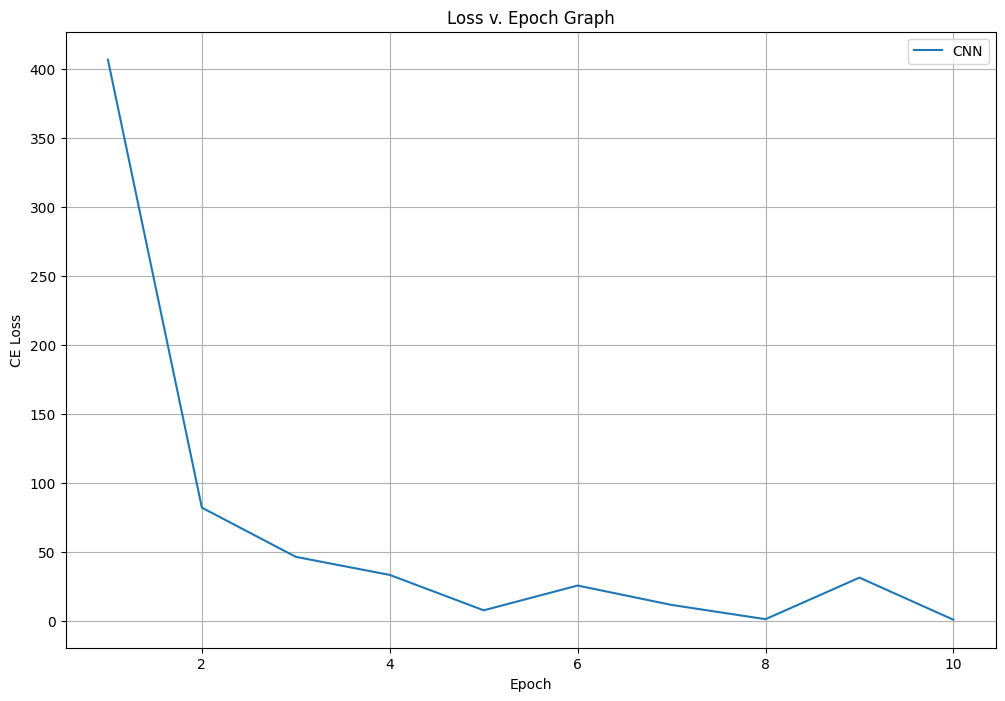

In [57]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Loss v. Epoch Graph
ax1.plot(range(1, epochSize+1), result['loss'], label="CNN")
ax1.legend()
ax1.grid()
ax1.set_title("Loss v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("CE Loss")

[]

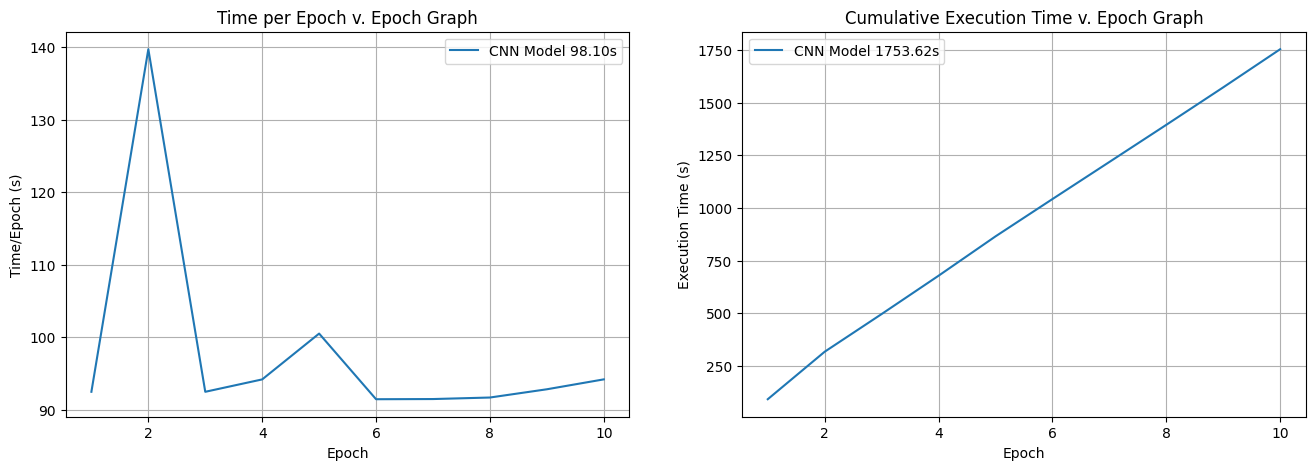

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Time per Epoch v. Epoch Graph
ax1.plot(range(1, epochSize+1), result['epoch_time'], label=f"CNN Model {np.mean(result['epoch_time']):.2f}s")
ax1.set_title("Time per Epoch v. Epoch Graph")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Time/Epoch (s)")
ax1.legend()
ax1.grid()

# Time per Epoch v. Epoch Graph
ax2.plot(range(1, epochSize+1), result['exec_time'], label=f"CNN Model {result['exec_time'][-1]:.2f}s")
ax2.set_title("Cumulative Execution Time v. Epoch Graph")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Execution Time (s)")
ax2.legend()
ax2.grid()
plt.plot()

In [59]:
def evaluate_model(model, data_loader, model_name=""): #or def compute_accuracy():  , use whatever conventions that you like

    model.eval()

    train_loader, test_loader = data_loader[0], data_loader[1]

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Train Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    print(f"{model_name} => Test Accuracy: {accuracy * 100:.2f}% || Correct Labels: {correct} / Wrong Labels: {total-correct}")

evaluate_model(model, [train_loader, test_loader], "CNN")

CNN => Train Accuracy: 100.00% || Correct Labels: 6600 / Wrong Labels: 0
CNN => Test Accuracy: 99.33% || Correct Labels: 1639 / Wrong Labels: 11


Text(0.5, 1.0, 'CNN Accuracy v. Epoch')

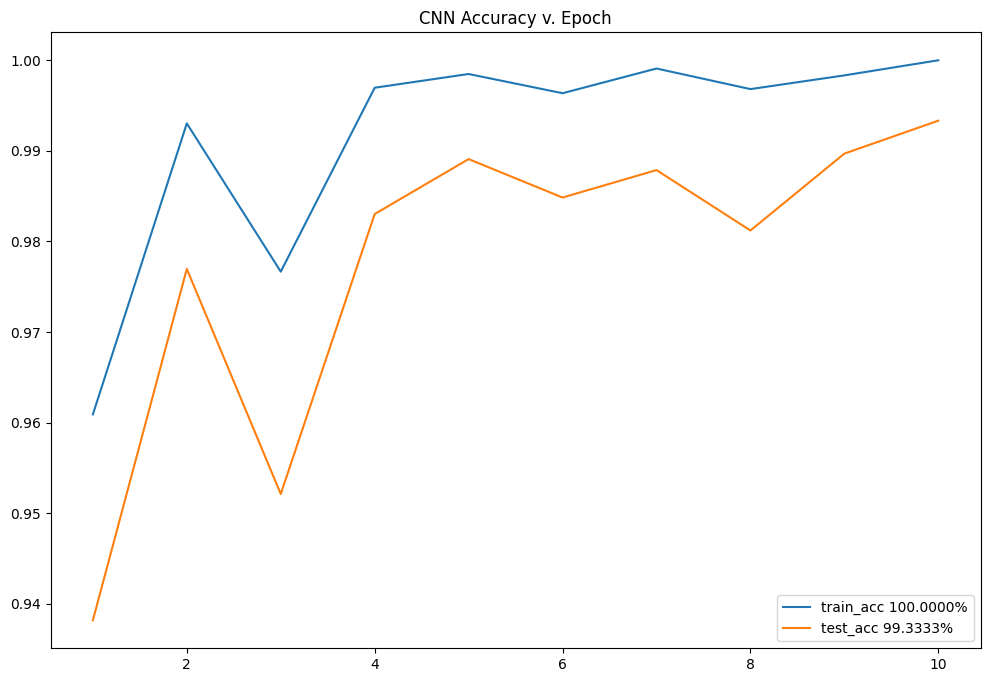

In [60]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Accuracy v. Epoch Graph
ax1.plot(range(1, epochSize+1), result['train_acc'], label=f"train_acc {result['train_acc'][-1]*100:.4f}%")
ax1.plot(range(1, epochSize+1), result['test_acc'], label=f"test_acc {result['test_acc'][-1]*100:.4f}%")
ax1.legend(loc='lower right')
ax1.set_title("CNN Accuracy v. Epoch")

In [61]:
# Save the model
torch.save(model.state_dict(), './models/model_v1.pth')
print("Saved!")

Saved!
